In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score

In [2]:
plt.style.use('dark_background')

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Работаем с датасетом `total_df.csv`.

Скачать его можно отсюда: https://disk.yandex.ru/d/PjQ13mEbT9958w

На данный момент в датасете 2720 вакансий 17416 резюме

Эти две таблицы соединены декартовым произведением, однако, доступно лишь  59,610 записей, которым был дан признак target, где 1 - это вакансия подходит для собеседования и 0 - эта вакансия не подходит для собеседования

25,520 -  значений target = 1

34,090 - значений target = 0

#### **Используемые столбцы:**

- `vacancy_id` - ID вакансии
- `vacancy_name` - Название вакансии (аналитик, ABAP-программист)
- `vacancy_area` - город, где размещена вакансия
- `vacancy_experience` - требуемый опыт работы
- `vacancy_employment` - тип занятости
- `vacancy_schedule` - график работы
- `vacancy_salary_from` - нижняя граница зарплатного интервала
- `vacancy_salary_to` - верхняя граница зарплатного интервала
- `vacancy_salary_currency` - тип валюты
- `vacancy_salary_gross` - gross или net
- `vacancy_description` - описание вакансии
- `resume_id` - ID резюме
- `resume_title` -  название резюме (аналитик, ABAP-программист)
- `resume_specialization` - специализация кандидата
- `resume_last_position` - последняя должность, на которой работал кандидат
- `resume_last_experience_description` - что делал кандидат на последнем месте работы
- `resume_last_company_experience_period` - срок работы на последнем месте
- `resume_skills` - навыки
- `resume_education` - образование, место
- `resume_courses` - курсы? сертификаты
- `resume_salary` - желаемая зарплата
- `resume_age` - возраст кандидата
- `resume_total_experience` - общая продолжительность стажа
- `resume_experience_months` - общая продолжительность стажа, записанная в месяцах
- `resume_location` - город, где находится кандидат
- `resume_gender` - пол кандидата
- `resume_applicant_status` - ищет активно или нет работу
- `target` - 1, если кандидат соответствует критериям для первого собеседования, 0 в противном случае
</div>

In [3]:
df = pd.read_csv('total_df.csv')
df.head()

,vacancy_id,vacancy_name,vacancy_area,vacancy_experience,vacancy_employment,vacancy_schedule,vacancy_salary_from,vacancy_salary_to,vacancy_salary_currency,vacancy_salary_gross,...,resume_education,resume_courses,resume_salary,resume_age,resume_total_experience,resume_experience_months,resume_location,resume_gender,resume_applicant_status,target
0,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,300000.0,NaN,RUR,False,...,['Казанский Авиационный Институт'],NaN,NaN,65.0,19 лет,228.0,Москва,Мужчина,Рассматривает предложения,1
1,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,300000.0,NaN,RUR,False,...,"['ООО ""Открытый Учебный Центр СофтБаланс"", г. ...","['ООО ""Открытый Учебный Центр СофтБаланс"", г. ...",NaN,43.0,17 лет 4 месяца,208.0,Москва,Мужчина,Рассматривает предложения,1
2,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,300000.0,NaN,RUR,False,...,['Орский государственный педагогический инстит...,NaN,200 000 ₽ на руки,52.0,30 лет,360.0,Москва,Женщина,NaN,1
3,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,300000.0,NaN,RUR,False,...,['Красноярский государственный университет'],NaN,500 000 ₽ на руки,56.0,29 лет 8 месяцев,356.0,Красноярск,Мужчина,Рассматривает предложения,1
4,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,300000.0,NaN,RUR,False,...,['Белоруский Гос. Университет Информатики и Ра...,"['SAP CIS, SAP XI', 'Школа Логистики МАДИ', 'S...",NaN,48.0,25 лет 1 месяц,301.0,Moscow,Male,NaN,1


In [4]:
df.shape

(59610, 28)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59610 entries, 0 to 59609
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   vacancy_id                             59610 non-null  int64  
 1   vacancy_name                           59610 non-null  object 
 2   vacancy_area                           59610 non-null  object 
 3   vacancy_experience                     59610 non-null  object 
 4   vacancy_employment                     59610 non-null  object 
 5   vacancy_schedule                       59610 non-null  object 
 6   vacancy_salary_from                    14031 non-null  float64
 7   vacancy_salary_to                      11257 non-null  float64
 8   vacancy_salary_currency                17597 non-null  object 
 9   vacancy_salary_gross                   17597 non-null  object 
 10  vacancy_description                    59610 non-null  object 
 11  re

In [6]:
df.duplicated().sum()

np.int64(0)

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Дубликатов не выявлено.
</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Посмотрим на пропуски отдельно по категориальным и числовым признакам.
</div>

In [7]:
nan_df = pd.DataFrame({'Количество пропусков': df.isna().sum(), 'Доля пропусков': (df.isna().sum() / len(df)).round(2)})

In [8]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

In [9]:
nan_df.loc[list(cat_cols)].sort_values('Доля пропусков', ascending=False)

,Количество пропусков,Доля пропусков
vacancy_salary_currency,42013,0.70
vacancy_salary_gross,42013,0.70
resume_applicant_status,40095,0.67
resume_courses,35899,0.60
resume_salary,26695,0.45
resume_skills,15136,0.25
resume_education,1520,0.03
resume_last_experience_description,1209,0.02
resume_total_experience,1009,0.02
resume_last_company_experience_period,1196,0.02


In [10]:
print('Разряженность датасета: ', round(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]), 4) * 100, '%')

Разряженность датасета:  18.41 %


In [11]:
nan_df.loc[list(num_cols)].sort_values('Доля пропусков', ascending=False)

,Количество пропусков,Доля пропусков
vacancy_salary_to,48353,0.81
vacancy_salary_from,45579,0.76
resume_age,3281,0.06
resume_experience_months,1009,0.02
vacancy_id,0,0.00
resume_id,0,0.00
target,0,0.00


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Пропущены значения у следующих параметров и по ним следующие причины отсутствия значений:

- vacancy_salary_to - работодатели редко дают зарплатные вилки, только если либо позицию им нужно (а) быстро закрыть (б) очистить входной поток, чтобы не было много невалидных подач (кандидатов с ожиданиями выше вакансии) (в) Скрыть высокие зарплаты
- vacancy_salary_from - работодатели редко дают зарплатные вилки, это им невыгодно по многим причинам. Вилки дают только если либо нужно (а) быстро закрыть позицию (б) очистить входной поток, чтобы не было много невалидных подач (кандидатов с ожиданиями выше вакансии)
- vacancy_salary_currency - вытекает из предыдущих параметров
- vacancy_salary_gross - вытекает из предыдущих параметров
- resume_applicant_status - статус аппликанта часто скрывается, если он в данный момент трудоустроен. По сути тут два типа резюме: активно ищущих и открытых предложениям.
- resume_courses - курсы кандидата на вакансию (список с названиями курсов). Необходимы для вакансий, где таковые курсы требуются. Людей таких много, курсы разные, будем ставить пустые списки у тех, у кого нет курсов
- resume_salary - Кандидаты также редко ставят ожидания по зарплатам открытыми
- resume_skills - скиллы, могут пересекаться с курсами. Это поле заметно чаще прописывают, чем курсы, потому что здесь не нужно подтверждение никакого. Пропуски говорят о незаполненном резюме.
- resume_age - вообще на hh почти скрыть возраст. Таких резюме меньше 5%. Значит, технические ошибки при парсинге, случайные сбои.
- resume_education - отсутствие образование также редкое явление. Неоконченное также указывают, поэтому либо решили только среднее не указывать, а оставить только курсы, либо технические ошибки при парсинге, случайные сбои
- resume_last_experience_description - Отсутствие опыта или технический сбой
- resume_last_position - вытекает из предыдущего
- resume_last_company_experience_period - вытекает из предыдущего
- resume_total_experience - Отсутствие опыта или технический сбой
- resume_experience_months - вытекает из предыдущего
- resume_specialization - технический сбой
- resume_location - технический сбой
- resume_gender - технический сбой
- resume_title - технический сбой

Отсюда вытекают 3 категории:

1. **Рандомные пропуски** Технические ошибки при парсинге, случайные сбои. К ним относятся поля для резюме - одновременное отсутствие всех данных кандидата, отсутствие каких-либо данных по кандидату, кроме профессии, в которую он стремиться, отсутствие специализации и опыта

2. **Не рандомные пропуски** Высокие зарплаты намеренно скрываются; кандидаты с пробелами в карьере не указывают даты

3. **Микс** - возможно включает технические сбои, возможно, намеренное скрытие. Требует детального рассмотрения каждого поля.

Не рандомные пропуски нужно отдельно обрабатывать, технические сбои - будут удалены из датасета

Т.к. у признаков vacancy_salary_to и vacancy_salary_from примерно 80% пропусков, то можно их удалить.

Поскольку vacancy_salary_currency и vacancy_salary_gross являются вытекающими признаками из vacancy_salary_*, то их тоже можно удалить

По техническим причинам, на hh.ru нельзя не указывать возраст. Однако, в датасете есть резюме без указания возраста. Заполним признак resume_age средним значением, а resume_experience_months заполним нулем, т.к. видно, что последнего места работы нет.

</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
В первую очередь уберем строки, где пропущены все ключевые значения в резюме:
</div>

In [12]:
t1 = df.shape[0]
df = df.dropna(subset= ["resume_education",
                        "resume_last_experience_description",
                        "resume_last_position",
                        "resume_last_company_experience_period",
                        "resume_total_experience",
                        "resume_experience_months",
                        "resume_location",
                        "resume_specialization",
                        "resume_gender",
                        "resume_title"], how="all")
t2 = df.shape[0]
print('Удалено ', t1 - t2 ,' строки')

Удалено  64  строки


In [13]:
t1 = df.shape[0]
df = df.dropna(subset= ["resume_education",
                        "resume_last_experience_description",
                        "resume_last_position",
                        "resume_last_company_experience_period",
                        "resume_total_experience",
                        "resume_experience_months",
                        "resume_location",
                        "resume_specialization"], how="all")
t2 = df.shape[0]
print('Удалена ', t1 - t2 ,' строка')

Удалена  1  строка


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Удалим еще те строки, где случился технический сбой в парсинге, где у кандидата общий опыт есть, а последний опыт не указан (и наоборот):
</div>

In [14]:
t1 = df.shape[0]
df = df.loc[~(df["resume_total_experience"].notna()
        & df["resume_last_experience_description"].isna()
        & df["resume_last_position"].isna())]
t2 = df.shape[0]
print('Удалено ', t1 - t2 ,' строк')

Удалено  188  строк


In [15]:
t1 = df.shape[0]
df = df.loc[~(df["resume_total_experience"].isna()
        & df["resume_last_experience_description"].notna()
        & df["resume_last_position"].notna())]
t2 = df.shape[0]
print('Удалено ', t1 - t2 ,' строк')

Удалено  0  строк


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Посмотрим на пропуски отдельно по категориальным и числовым признакам.
</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Преобразуем сначала ожидаемые зарплаты
</div>

In [16]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

In [17]:
df[cat_cols] = df[cat_cols].fillna('NDT')

In [18]:
df.loc[df['resume_experience_months'].isna(), 'resume_last_experience_description'].unique()

array(['NDT'], dtype=object)

In [19]:
df['resume_age'] = df['resume_age'].fillna(df['resume_age'].mean())
df['resume_experience_months'] = df['resume_experience_months'].fillna(0)

In [20]:
df = df.drop(['vacancy_id', 'resume_id', 'vacancy_salary_to', 'vacancy_salary_from',
              'vacancy_salary_currency', 'vacancy_salary_gross'], axis=1)

In [21]:
df.loc[df['resume_last_company_experience_period'] == 'NDT', 'resume_last_experience_description'].unique()

array(['NDT'], dtype=object)

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Преобразуем сначала ожидаемые зарплаты
</div>

In [22]:
df['resume_salary_split'] = df['resume_salary'].apply(lambda x: x.split())

df['salary_int'] = df['resume_salary_split'].apply(
    lambda x: int(''.join(part for part in x if re.fullmatch(r'\d+', part)))
              if any(re.fullmatch(r'\d+', part) for part in x)
              else np.nan
)

currency_symbols = ['₽', '$', '€', '₴', '₸', '₼', '₾', 'Br', "so'm"]

rates_rub = {
    "₽": 1.0,
    "$": 80.85,
    "€": 94.14,
    "₴": 1.94,
    "₸": 0.150,
    "₼": 47.8,
    "₾": 33.5,
    "Br": 28.7,
    "so'm": 0.0068
}

df['currency_symbol'] = df['resume_salary_split'].apply(
    lambda x: next((sym for sym in x if sym in currency_symbols), np.nan)
)

df['salary_converted'] = (df['salary_int'] * df['currency_symbol'].map(rates_rub)).fillna(0)

df['resume_salary'] = df['salary_converted']

df = df.drop(['resume_salary_split', 'salary_int', 'currency_symbol', 'salary_converted'], axis=1)

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Добавим дополнительный столбец с опытом работы в последней компании в месяцах для удобства
</div>

In [23]:
def experience_to_months(experience_text):
    months = 0
    # Опыт в годах
    years_match = re.search(r'(\d+)\s*год', experience_text)
    if years_match:
        months += int(years_match.group(1)) * 12

    years_match = re.search(r'(\d+)\s*лет', experience_text)
    if years_match:
        months += int(years_match.group(1)) * 12

    # Опыт в месяцах
    months_match = re.search(r'(\d+)\s*месяц', experience_text)
    if months_match:
        months += int(months_match.group(1))

    return months if months > 0 else np.nan

In [24]:
df['resume_last_company_experience_months'] = df['resume_last_company_experience_period'].apply(experience_to_months)

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Т.к. в названии компании стоит NDT, можно столбец resume_last_company_experience_months заполнять нулевыми значениями.
</div>

In [25]:
df['resume_last_company_experience_months'] = df['resume_last_company_experience_months'].fillna(0)

In [26]:
df = df.drop(['resume_last_company_experience_period', 'resume_total_experience'], axis=1)

In [27]:
print('Разряженность датасета: ', round(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]), 4) * 100, '%')

Разряженность датасета:  0.0 %


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Отлично! Пропущенные значения в датасете мы заполнили. Перейдем к следующему этапу, необходимо разобраться с выбросами и ошибочными значениями.
</div>

In [28]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
vacancy_name,59357,2720,DevOps-инженер,1534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_area,59357,23,Москва,58590,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_experience,59357,4,От 3 до 6 лет,32092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_employment,59357,3,Полная занятость,57574,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_schedule,59357,5,Удаленная работа,29855,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_description,59357,3382,ООО «Исратэк» — 30 лет в производстве самоклея...,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
resume_title,59357,10810,Технический директор,1376,NaN,NaN,NaN,NaN,NaN,NaN,NaN
resume_specialization,59357,1687,"['Программист, разработчик']",14365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
resume_last_position,59357,10307,Технический директор,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
resume_last_experience_description,59357,16826,NDT,956,NaN,NaN,NaN,NaN,NaN,NaN,NaN


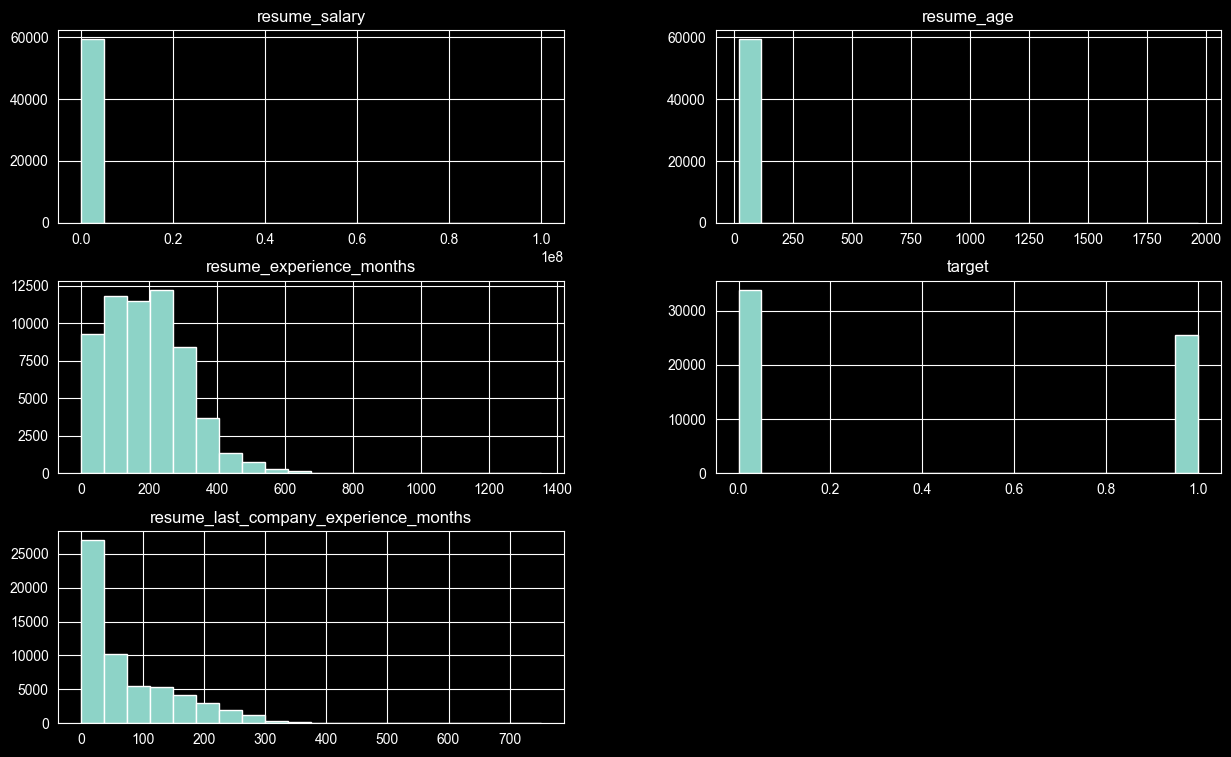

In [29]:
df.hist(bins=20, figsize=(15, 9));

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

- Ограничим выбросы по зарплате, потому что ровно одно значение по ожидаемой заработоной плате = 999,999,999 (смешно, но нет)

- Ограничим опыт общий и внутри одной компании до 720 месяцев (60 лет, ничего себе уже)

- Уберем возраст > 90, не ждем, что эти кандидаты находятся в поиске вакансии
</div>

In [30]:
df = df[~(df.resume_salary > 1e7)]
df.loc[df['resume_experience_months'] > 720, 'resume_experience_months'] = 720
df.loc[df['resume_last_company_experience_months'] > 720, 'resume_last_company_experience_months'] = 720
df = df[~(df.resume_age > 90)]



<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

- Также уберем строки, где последний опыт кандидата больше, чем общий

- И где общий опыт кандидата +16 лет больше чем возраст (хоть так)

</div>

In [31]:
df = df[~(df.resume_experience_months < df.resume_last_company_experience_months)]
df = df[~(df.resume_age < (df.resume_experience_months // 12) + 16)]

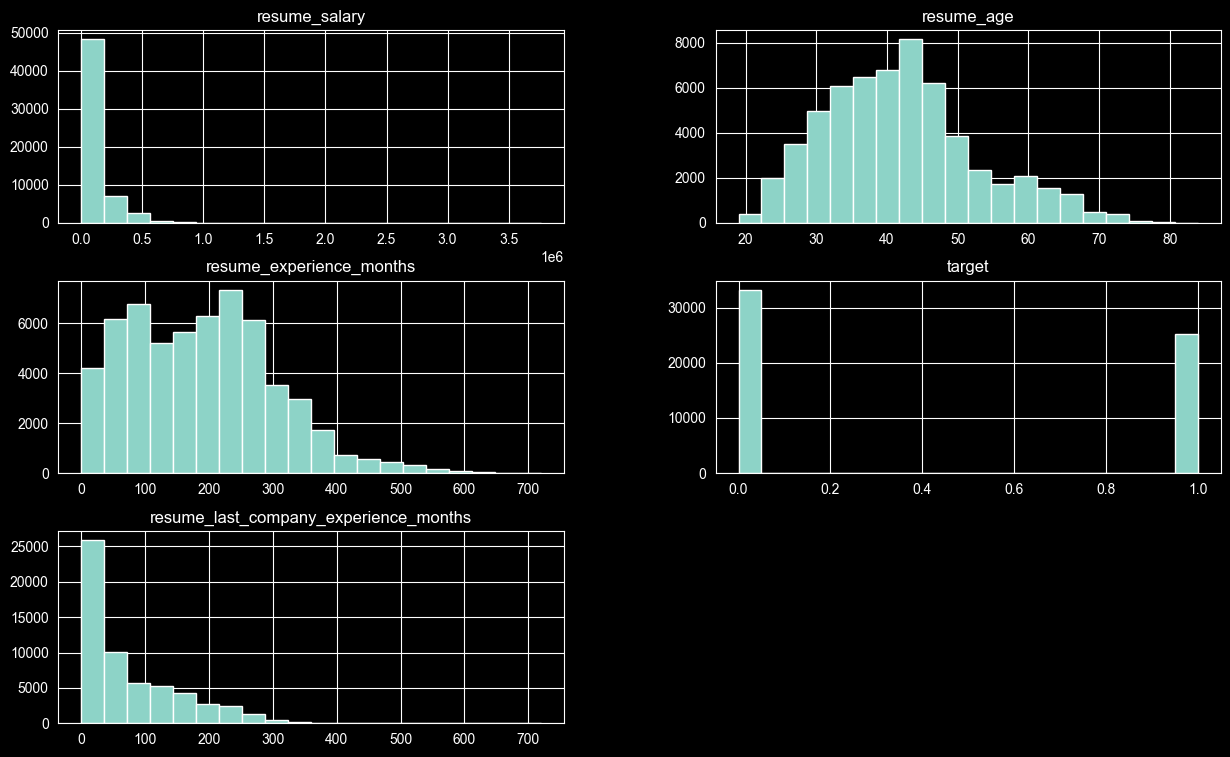

In [32]:
df.hist(bins=20, figsize=(15, 9));

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Теперь приведем остальные значения в датасете к порядку:
</div>

In [33]:
# Заменим текущий формат разброса полов в датасете на унифицированный:

gender_map = {
    'Мужчина': 'Мужчина',
    'Male': 'Мужчина',
    'Женщина': 'Женщина',
    'Female': 'Женщина'
}

df['resume_gender'] = df['resume_gender'].apply(lambda x: gender_map[x] if x in gender_map else 'Неизвестно')

In [34]:
# Поправим значения статуса кандидатов:

df["resume_applicant_status"] = df["resume_applicant_status"].replace("Есть подтверждённые навыки", "Рассматривает предложения")
df["resume_applicant_status"] = df["resume_applicant_status"].replace("NDT", "Рассматривает предложения")

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Теперь, когда мы привели данные к нужному виду, избавились от пропусков и выбросов в данных, проверили датасет на ошибки, можно приступить к изучению влияния признаков на целевую переменную:

</div>

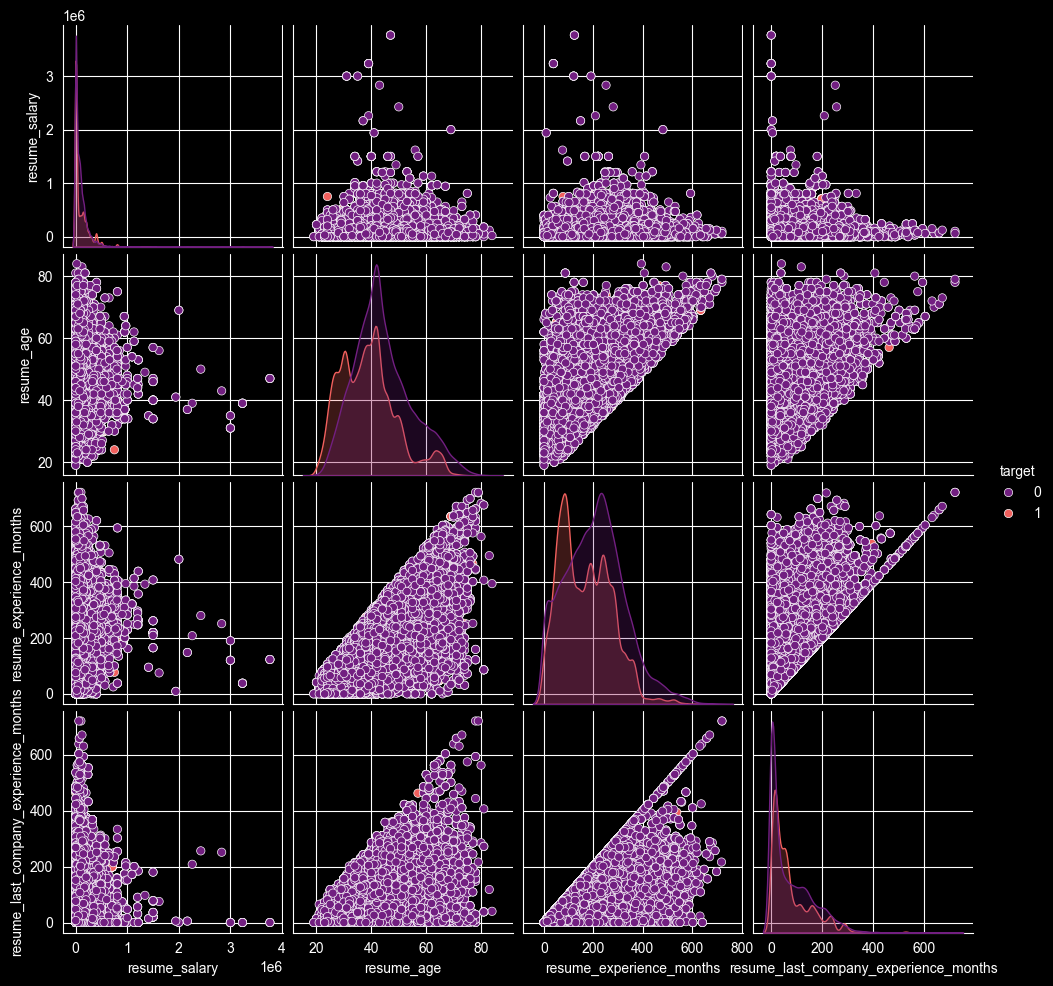

In [35]:
sns.pairplot(df, hue="target", palette="magma");

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Будем исследовать сначала количественные признаки

Заметим несколько понятных вещей:

- возраст кандидата и зарплата имеют колоколообразное распределение, медиана зарплат наступает в среднем возрасте. В начале карьерного опыта кандидаты ожидают получать меньше, чем более опытные кандидаты и кандидаты пенсионного возраста также начинают требовать меньших зарплат с увеличением возраста

- Распределение зарплат и всего опыта кандидата имеет похожее распределенеие.

- Однако, последние опыт кандидата и его зарплатные ожидания имеют строго отрицательную взаимосвязь. Нужно будет посмотреть, как это связано вкупе с возрастом

- Опыт (общий и последний) и возраст строго сонаправлены, что не имеет для нас ценности, убеждаемся еще раз, что ошибок в данных нет)

</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Дальнейшее разбиение количественных показателей на Target / Gender / Vacancy experience / Resume applicant status / Resume location
не дали каких-то интересных зависимостей

Рассмотрим дальше корреляцию между признаками

Будем дальше рассматривать количественные и качественные признаки более детально

</div>

In [36]:
def correlation_check(df, metric_x, metric_y):

    phik_corr = df[[metric_x, metric_y]].phik_matrix(interval_cols=[metric_x, metric_y]).loc[metric_x, metric_y]
    pearson_corr = df[metric_x].corr(df[metric_y], method='pearson')

    return pearson_corr, phik_corr


In [37]:
out = []
columns = ['resume_salary', 'resume_age', 'resume_experience_months', 'resume_last_company_experience_months']
for k in range(len(columns)):
    metric_x = columns[k]
    for p in columns[k+1::]:
        metric_y = p
        pearson_corr, phik_corr = correlation_check(df, metric_x, metric_y)
        out.append([metric_x, metric_y, pearson_corr, phik_corr])
corr_table = pd.DataFrame(out, columns=['metric_x', 'metric_y', 'Линейная корреляция', 'Нелинейная корреляция'])
corr_table

,metric_x,metric_y,Линейная корреляция,Нелинейная корреляция
0,resume_salary,resume_age,0.040796,0.096857
1,resume_salary,resume_experience_months,0.083561,0.117970
2,resume_salary,resume_last_company_experience_months,-0.021658,0.105492
3,resume_age,resume_experience_months,0.734185,0.817811
4,resume_age,resume_last_company_experience_months,0.325771,0.463767
5,resume_experience_months,resume_last_company_experience_months,0.499399,0.752295


In [38]:
out = []
columns = ['resume_salary', 'resume_age', 'resume_experience_months', 'resume_last_company_experience_months']
for k in range(len(columns)):
    metric_x = columns[k]
    for p in columns[k+1::]:
        metric_y = p
        pearson_corr, phik_corr = correlation_check(df[df.target == 1], metric_x, metric_y)
        out.append([metric_x, metric_y, pearson_corr, phik_corr])
corr_table = pd.DataFrame(out, columns=['metric_x', 'metric_y', 'Линейная корреляция', 'Нелинейная корреляция'])
corr_table

,metric_x,metric_y,Линейная корреляция,Нелинейная корреляция
0,resume_salary,resume_age,0.021366,0.217176
1,resume_salary,resume_experience_months,0.051512,0.209508
2,resume_salary,resume_last_company_experience_months,-0.039606,0.159216
3,resume_age,resume_experience_months,0.778349,0.829714
4,resume_age,resume_last_company_experience_months,0.393032,0.638038
5,resume_experience_months,resume_last_company_experience_months,0.533785,0.796611


In [39]:
out = []
columns = ['resume_salary', 'resume_age', 'resume_experience_months', 'resume_last_company_experience_months']
for k in range(len(columns)):
    metric_x = columns[k]
    for p in columns[k+1::]:
        metric_y = p
        pearson_corr, phik_corr = correlation_check(df[df.resume_gender == 'Мужчина'], metric_x, metric_y)
        out.append([metric_x, metric_y, pearson_corr, phik_corr])
corr_table = pd.DataFrame(out, columns=['metric_x', 'metric_y', 'Линейная корреляция', 'Нелинейная корреляция'])
corr_table

,metric_x,metric_y,Линейная корреляция,Нелинейная корреляция
0,resume_salary,resume_age,0.037755,0.078272
1,resume_salary,resume_experience_months,0.082509,0.092022
2,resume_salary,resume_last_company_experience_months,-0.032027,0.085987
3,resume_age,resume_experience_months,0.742615,0.824658
4,resume_age,resume_last_company_experience_months,0.319084,0.472274
5,resume_experience_months,resume_last_company_experience_months,0.495847,0.744822


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Каких-то интересных корреляций найдено не было

</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Построим нужные нам графики и начнем с конца, будем изучать влияния признаков в резюме на принятие и отказ

Напомниаю:
 - target = 1 - кандидата позвали на эту вакансию,
 - target = 0 - кандидата НЕ позвали на эту вакансию
</div>

In [40]:
def create_bar_chart(df, metric):

    t1 = ((df[df.target == 1].groupby([metric]).target.count() /\
          df.groupby([metric]).target.count()) * 100).reset_index()
    t1 = t1.merge(df[df.target == 1].groupby([metric]).target.count(), how='left', on = [metric])
    t1.rename(columns={'target_x': 1, 'target_y': 'cnt_1'}, inplace=True)

    t0 = ((df[df.target == 0].groupby([metric]).target.count() /\
          df.groupby([metric]).target.count()) * 100).reset_index()
    t0 = t0.merge(df[df.target == 0].groupby([metric]).target.count(), how='left', on = [metric])
    t0.rename(columns={'target_x': 0, 'target_y': 'cnt_0'}, inplace=True)

    t = t1.merge(t0, how='left', on = [metric])

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(t[metric], t[0], label='Target = 0', color='red')
    ax.bar(t[metric], t[1], bottom=t[0], label='Target = 1', color='blue')

    ax.set_title(f"Распределение целевого признака по {metric}", fontsize=14)
    ax.set_xlabel(metric)
    ax.set_ylabel("%")
    ax.set_ylim(0, 100)
    ax.legend(title="Target")

    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()

    return plt.show()

In [41]:
def create_scatter_chart(df, metric):

    t1 = ((df[df.target == 1].groupby([metric]).target.count() /\
          df.groupby([metric]).target.count()) * 100).reset_index()
    t1 = t1.merge(df[df.target == 1].groupby([metric]).target.count(), how='left', on = [metric])
    t1.rename(columns={'target_x': 1, 'target_y': 'cnt_1'}, inplace=True)

    t0 = ((df[df.target == 0].groupby([metric]).target.count() /\
          df.groupby([metric]).target.count()) * 100).reset_index()
    t0 = t0.merge(df[df.target == 0].groupby([metric]).target.count(), how='left', on = [metric])
    t0.rename(columns={'target_x': 0, 'target_y': 'cnt_0'}, inplace=True)

    t = t1.merge(t0, how='left', on = [metric])

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(t[metric], t[0], label="Target = 0", color='red')
    ax.fill_between(t[metric], t[0], color='red', alpha=0.3)

    ax.plot(t[metric], t[1], label="Target = 1", color='blue')
    ax.fill_between(t[metric], t[1], color='blue', alpha=0.3)

    ax.set_title(f"Распределение целевого признака по {metric}", fontsize=14)
    ax.set_xlabel(metric)
    ax.set_ylabel("%")
    ax.set_ylim(0, 100)
    ax.legend(title="Target")
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()

    return plt.show()

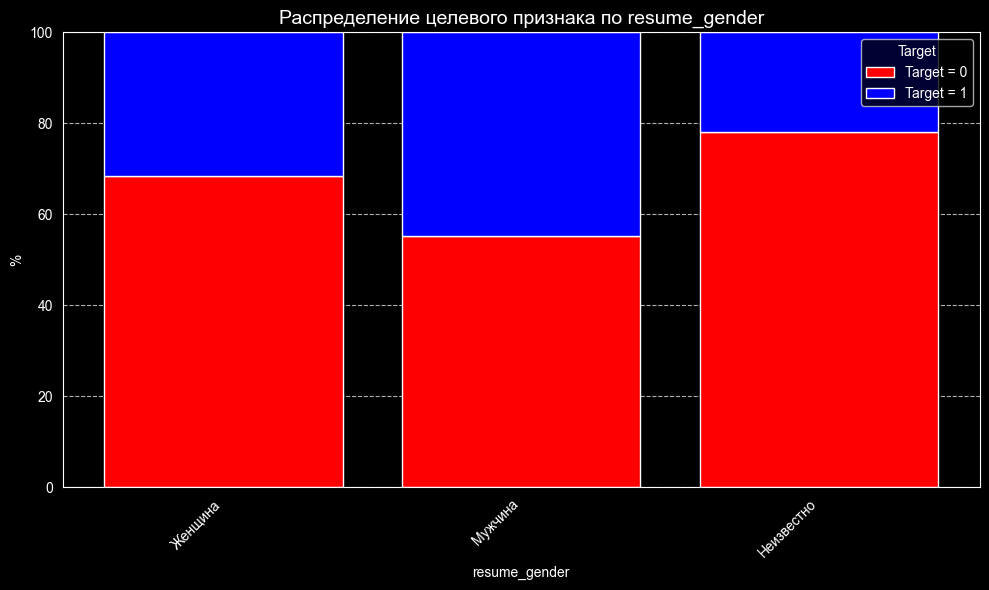

In [42]:
create_bar_chart(df, 'resume_gender')

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Мужчин гораздо чаще принимают на вакансию (относительно на 42% больше)

</div>

In [43]:
df.groupby('resume_gender').target.count() / df.target.count()

resume_gender
Женщина       0.126549
Мужчина       0.870249
Неизвестно    0.003201
Name: target, dtype: float64

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Также, заметим, что мужчины составляют 87% от датасета (не сами резюме, а матчинг вакансия - резюме)
</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Рассмотрим влияние возраста на таргет:

</div>

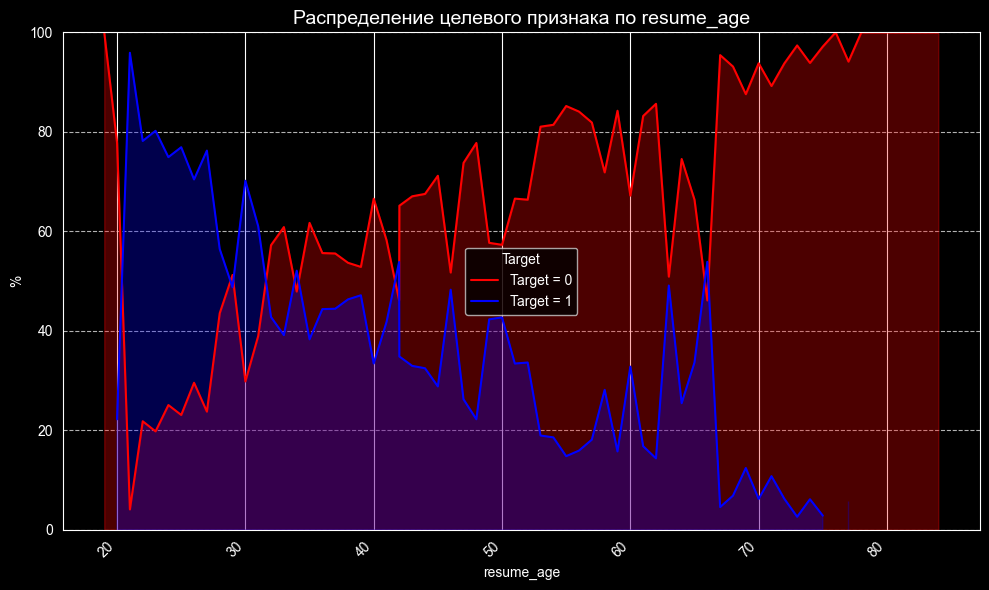

In [44]:
create_scatter_chart(df, 'resume_age')

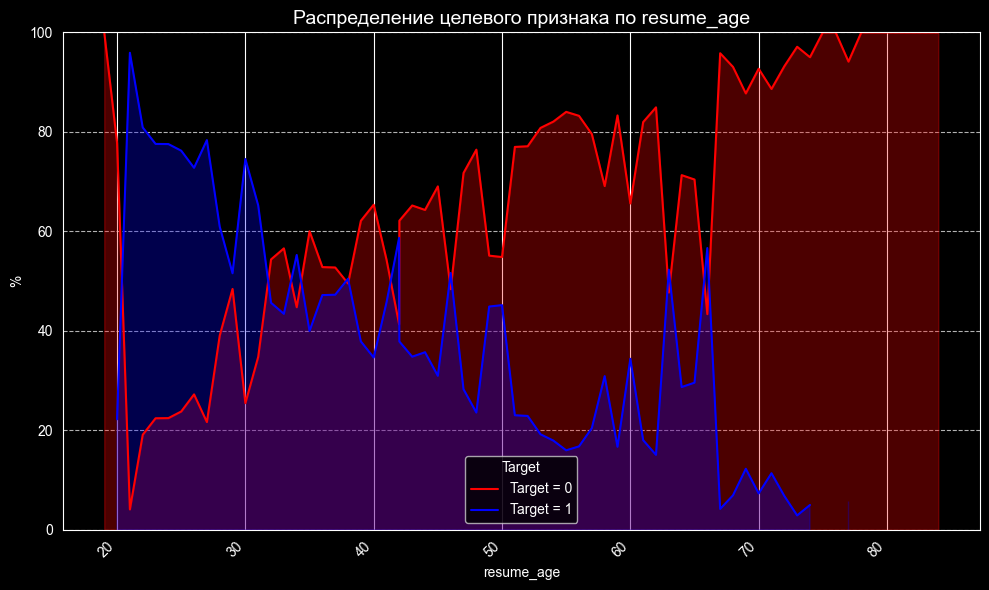

In [45]:
create_scatter_chart(df[df.resume_gender == 'Мужчина'], 'resume_age')

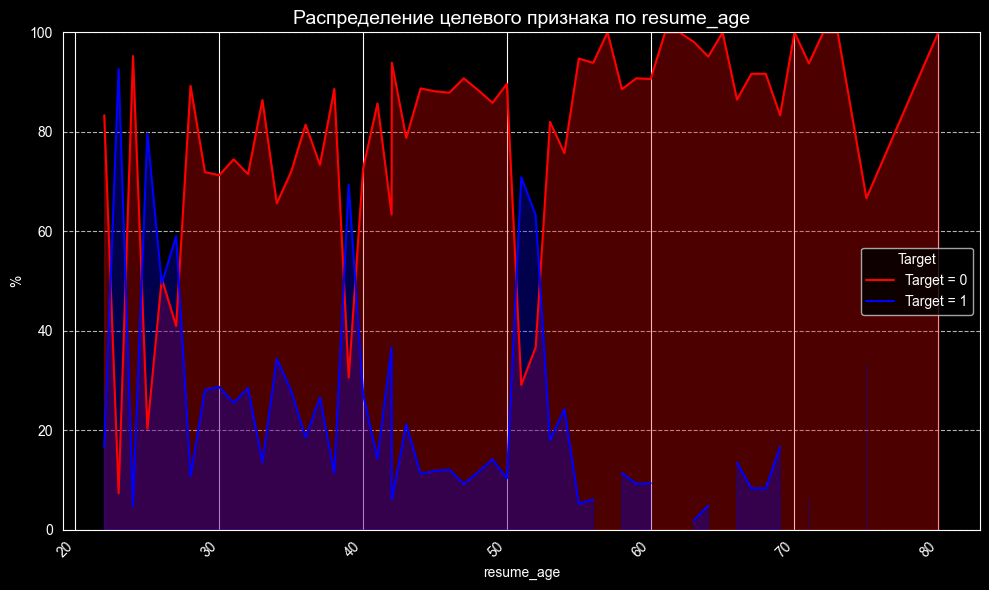

In [46]:
create_scatter_chart(df[df.resume_gender == 'Женщина'], 'resume_age')

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Видим линейную зависимость: чем больше возраст, тем выше доля отказов, как у женщин, так и мужчин.

Но надо сразу отметить, что у женщин доля отказов достигает 80% гораздо раньше, чем у мужчин (28 лет у женщин против 54 лет у мужчин)

</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Теперь рассмотрим влияние ожидаемой заработной платы на таргет

Для этого поделим зарплату на разные бакеты, чтобы график читался легче

</div>

/var/folders/xs/dv8c_70n5xlb5kqv6rsplk15q5qd1j/T/ipykernel_8189/2652169055.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t1 = ((df[df.target == 1].groupby([metric]).target.count() /\
/var/folders/xs/dv8c_70n5xlb5kqv6rsplk15q5qd1j/T/ipykernel_8189/2652169055.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([metric]).target.count()) * 100).reset_index()
/var/folders/xs/dv8c_70n5xlb5kqv6rsplk15q5qd1j/T/ipykernel_8189/2652169055.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

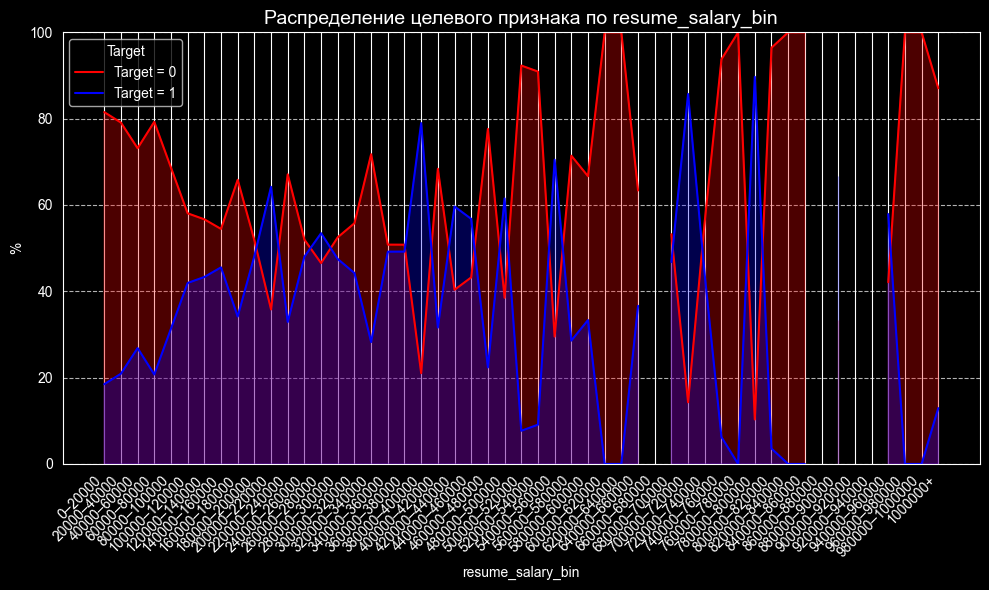

In [47]:
bucket = list(range(0, 1_000_001, 20_000)) + [np.inf]

labels = [f"{bucket[i]}–{bucket[i+1]}" for i in range(len(bucket)-2)] + ["1000000+"]

df["resume_salary_bin"] = pd.cut(
    df["resume_salary"],
    bins=bucket,
    labels=labels,
    include_lowest=True
)

create_scatter_chart(df[(df.resume_salary > 0)], 'resume_salary_bin')


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Линейной зависимости не наблюдается, разброс значений с ростом зарплаты, скорее, говорит о снижении кол-во наблюдений в датасете, чем о паттерне.

</div>

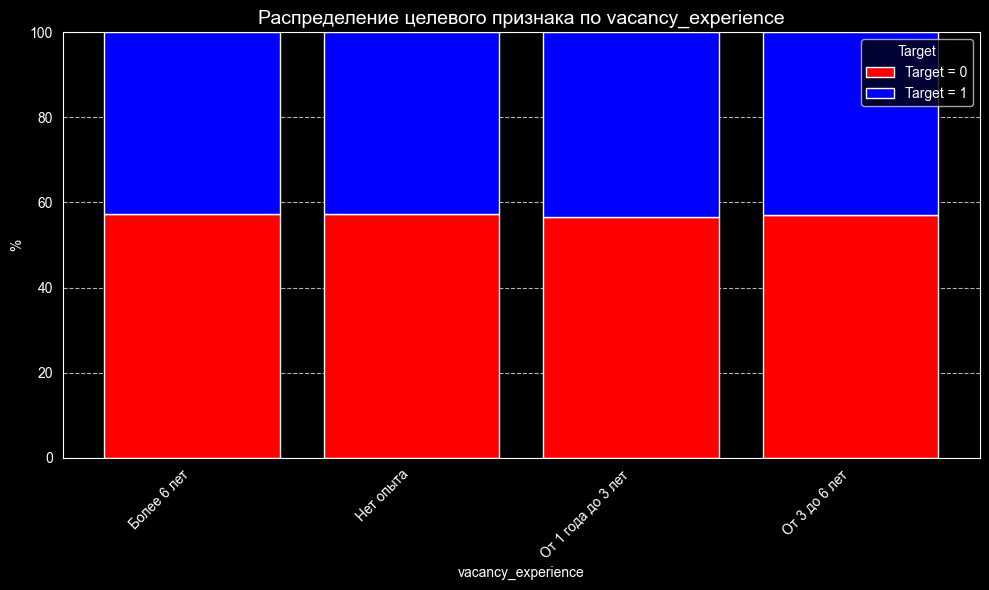

In [48]:
create_bar_chart(df, 'vacancy_experience')

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Идеально) Одинаковый уровень принятия на все вакансии

</div>

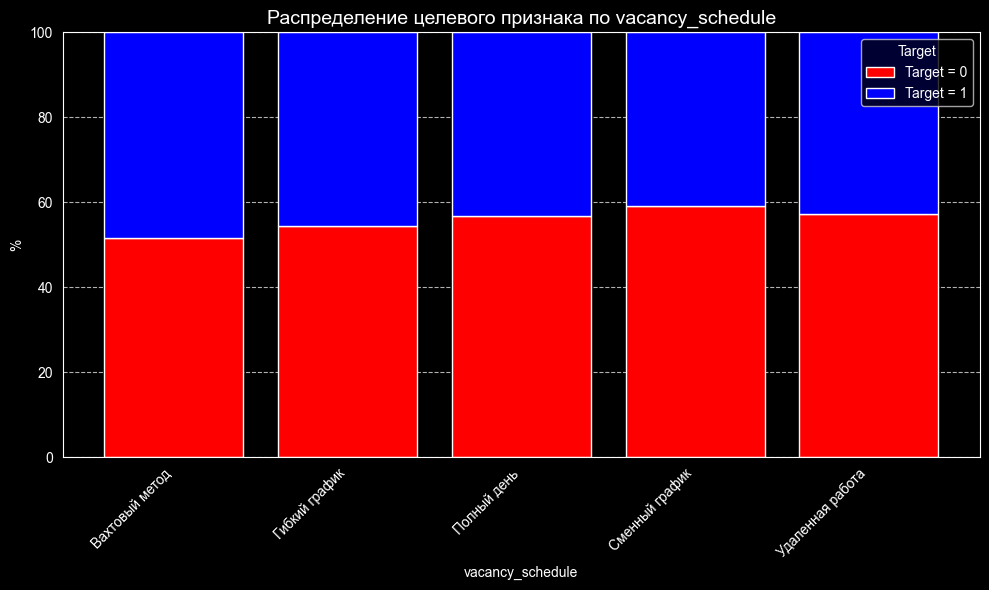

In [49]:
create_bar_chart(df, 'vacancy_schedule')

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Также, имеем примерно одинаковый уровень принятия

</div>

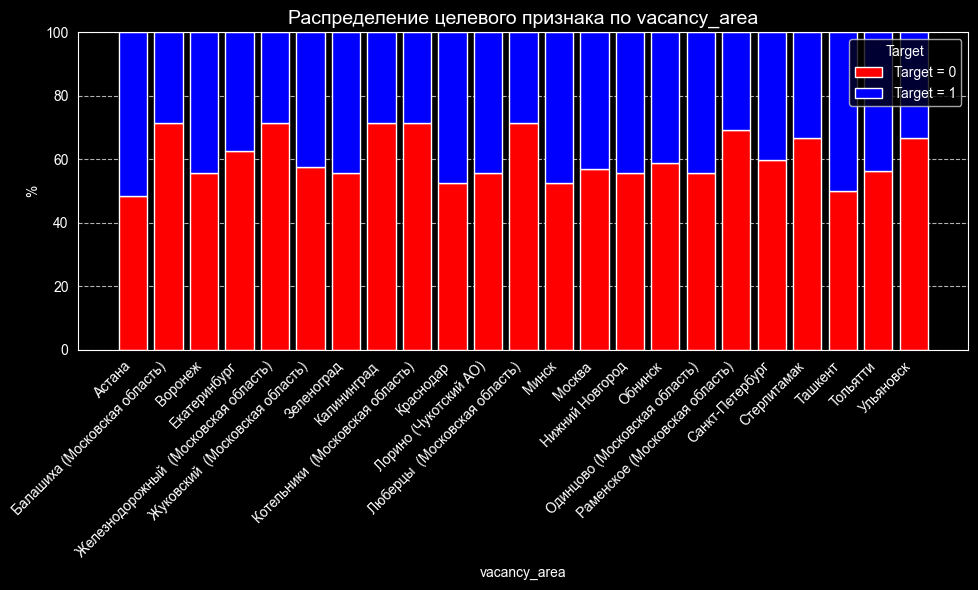

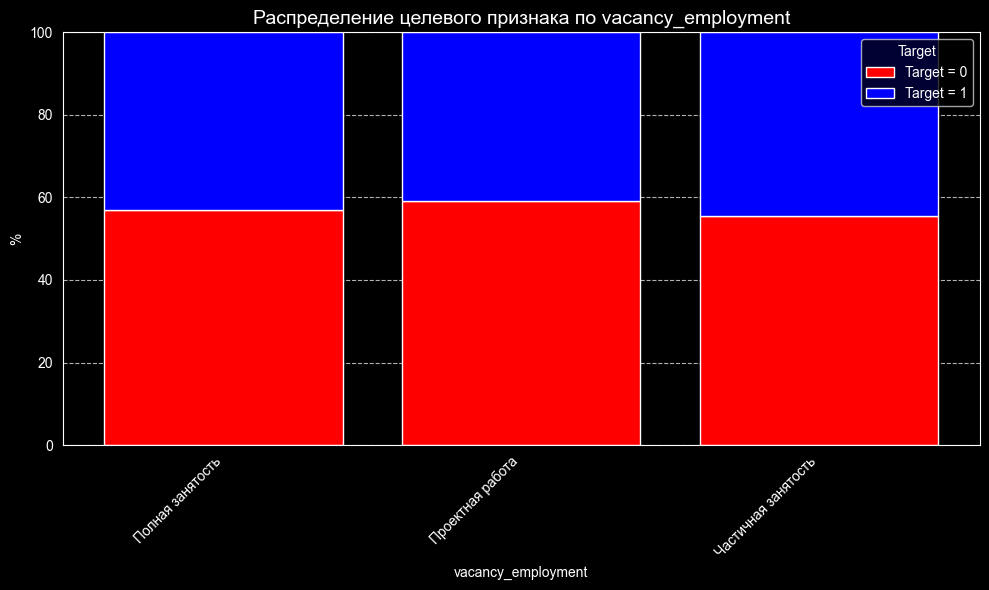

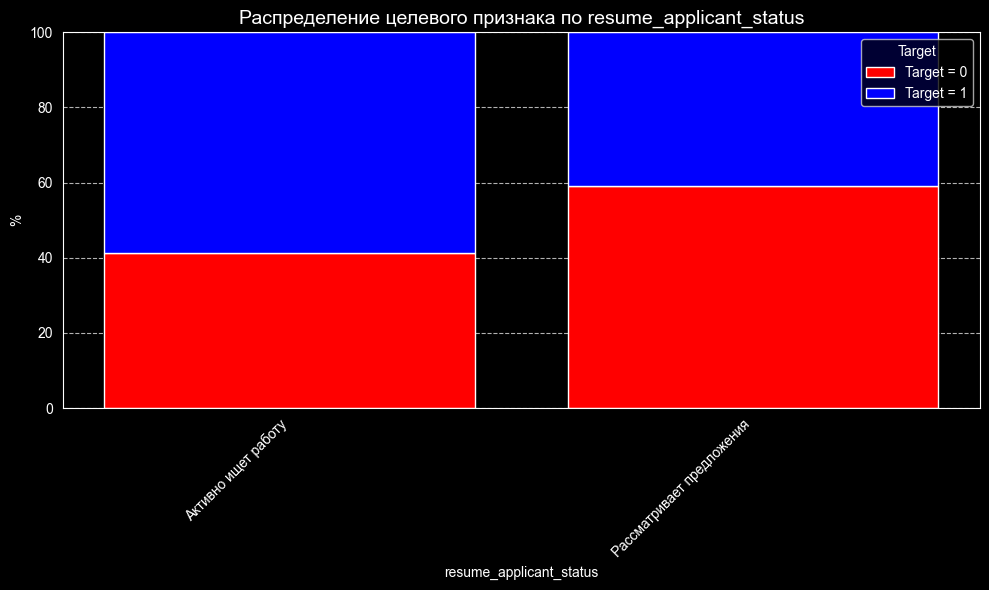

In [50]:
create_bar_chart(df, 'vacancy_area')
create_bar_chart(df, 'vacancy_employment')
create_bar_chart(df, 'resume_applicant_status')

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Рассмотрели категориальные признаки, которые имели меньше 100 уникальных значений

У resume_location - 570 уникальных значений

Из интересного только то, что есть разный уровень принятия у тех, кто активно ищет работу и тех, кто только рассматривает предложения.

</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

***ВЫВОД***

**Что было сделано с датасетом в ходе EDA**

- Очистили датасет от пропущенных значений (или придумали, как их заменить), данные были приведены в порядок и нормализованы. Выбросы, ошибки были удалены

- Удалили признаки зарплатных вилок, так как они имели подавляющее большинство пропусков и не могли быть адекватно заменены.

- Датасет был построен, как декартово произведение вакансий и резюме (2 720 вакансий, 17 416 резюме), из которых только 59 610 пар были оценены.

**Интересные наблюдения**

- Возраст и зарплата имеют колоколообразное распределение медиана зарплат приходится на средний возраст.
- Возраст и опыт - сонаправленные признаки
- Зарплата опыт и корреляция умеренно положительная: более опытные кандидаты ожидают вышее вознаграждение.
- Последний опыт и зарплата - отмечена отрицательная взаимосвязь: кандидаты, долго работающие на одном месте, в среднем ожидают меньше


**Половые  и возрастные дискриминации**
- Мужчины получают приглашения примерно на 42 % чаще, чем женщины.
- С возрастом доля отказов растёт у обоих полов, но у женщин резче
- Активно ищущие работу кандидаты получают заметно больше приглашений, чем те, кто только открыт предложениям


**Что делаем дальше**
- Учтем факторы пола, возраста, статуса поиска работы - они имеют влияние на целевую переменную
- Устраним сильную мультиколлинеарную зависимость между признаками (возраст, опыт общий, опыт последнего места)
- Построим новый признак учет локаций (возможно возьмем расстояние между ними)
- Строим baseline - TF-IDF по косинусному сходству



</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Попробуем сделать первый бейслайн

Построим первый бейслайн легкий: tf-idf для столбцов:

vacancy_columns = ['vacancy_name', 'vacancy_description']

resume_columns = ['resume_title', 'resume_specialization', 'resume_last_position', 'resume_last_experience_description', 'resume_skills', 'resume_courses']

Построим векторы слов для этих столбцов

Затем посомтрим на косиносное сходство между текстом в резюме и текстом в вакансиях

</div>

In [51]:
temp = df.copy()

In [52]:
def clean_text(s):
    remove = [
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        '.', ',', '!', '?', ':', ';', '-', '—', '–', '(', ')',
        '[', ']', '{', '}', '"', "'", '«', '»', '…', '⋯',
        '/', '\\', '|', '@', '#', '$', '%', '^', '&', '*', '_',
        '+', '=', '<', '>', '~', '`','\r','\n'
    ]
    clean = ' '
    for ch in s:
        if ch not in remove:
            clean += ch
    return clean

In [53]:
for k in ['vacancy_name', 'vacancy_description', 'resume_title', 'resume_specialization', 'resume_last_position', 'resume_last_experience_description', 'resume_skills', 'resume_courses']:
    temp[k] = temp[k].apply(lambda x: clean_text(x))

In [54]:
temp["vacancy_text"] = (temp["vacancy_name"].fillna("") + " " + temp["vacancy_description"].fillna(""))

temp["resume_text"] = (
    temp["resume_title"].fillna("") + " " +
    temp["resume_specialization"].fillna("") + " " +
    temp["resume_last_position"].fillna("") + " " +
    temp["resume_last_experience_description"].fillna("") + " " +
    temp["resume_skills"].fillna("") + " " +
    temp["resume_courses"].fillna("")
)

cp = pd.concat([temp["vacancy_text"], temp["resume_text"]], axis=0)

vector = TfidfVectorizer(ngram_range=(1, 2))
X = vector.fit_transform(cp)

n = len(temp)
X_vac = X[:n]
X_res = X[n:]

cos = (X_vac.multiply(X_res)).sum(axis=1).A1
temp["cosine_similarity"] = cos
temp[["vacancy_name", "resume_title", "cosine_similarity"]].head()

,vacancy_name,resume_title,cosine_similarity
0,Разработчик SAP ABAP,ABAPразработчик,0.148594
1,Разработчик SAP ABAP,ABAP разработчик SAP HCM CRM SHANA ERPFI TR,0.177950
2,Разработчик SAP ABAP,Разработчик ABAP,0.121084
3,Разработчик SAP ABAP,ABAPразработчик,0.124978
4,Разработчик SAP ABAP,ABAP разработчик Senior ABAP Developer SAP Te...,0.187168


In [55]:
y = temp["target"]
y_pred = temp["cosine_similarity"]

auc = roc_auc_score(y, y_pred)
print('ROC AUC:', auc)

temp.groupby('target')['cosine_similarity'].mean()


ROC AUC: 0.985871795813698


target
0    0.004259
1    0.040051
Name: cosine_similarity, dtype: float64

<Axes: title={'center': 'cosine_similarity'}, xlabel='target'>

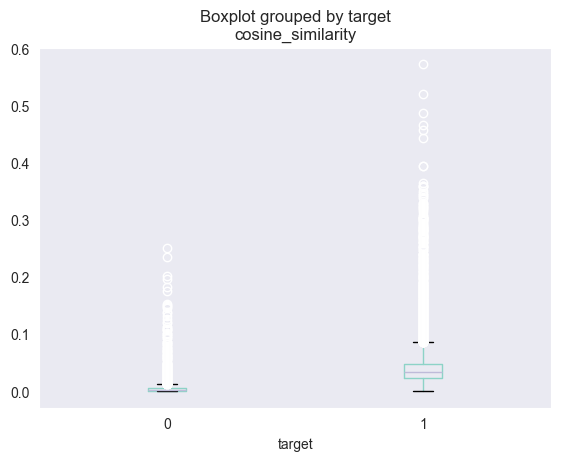

In [56]:
temp.boxplot(column="cosine_similarity", by="target", grid=False)

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

TF-IDF с косинусным сходством дает не самый плохой результат, видно, что косинусное сходство у резюме с targe = 1 выше, чем у target = 0.
Выходит, у нас результаты нерандомные и их можно использовать, как baseline.

</div>
